# Hyperparameter Scheduling with Callbacks
---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hyperparameter-Scheduling-with-Callbacks" data-toc-modified-id="Hyperparameter-Scheduling-with-Callbacks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hyperparameter Scheduling with Callbacks</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Initialize" data-toc-modified-id="Initialize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Initialize</a></span></li></ul></li><li><span><a href="#Hyperparameter-Scheduler" data-toc-modified-id="Hyperparameter-Scheduler-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hyperparameter Scheduler</a></span><ul class="toc-item"><li><span><a href="#Recorder-Callback" data-toc-modified-id="Recorder-Callback-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Recorder Callback</a></span></li><li><span><a href="#Scheduler-Callback" data-toc-modified-id="Scheduler-Callback-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Scheduler Callback</a></span></li></ul></li><li><span><a href="#Cyclical-Learning-Rates" data-toc-modified-id="Cyclical-Learning-Rates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cyclical Learning Rates</a></span><ul class="toc-item"><li><span><a href="#Scheduling-Functions" data-toc-modified-id="Scheduling-Functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Scheduling Functions</a></span></li><li><span><a href="#Mixed-Schedules" data-toc-modified-id="Mixed-Schedules-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Mixed Schedules</a></span></li><li><span><a href="#One-Cycle-Learning-Rate-Policy" data-toc-modified-id="One-Cycle-Learning-Rate-Policy-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>One Cycle Learning Rate Policy</a></span></li><li><span><a href="#Stochastic-Gradient-with-Restarts" data-toc-modified-id="Stochastic-Gradient-with-Restarts-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Stochastic Gradient with Restarts</a></span></li></ul></li><li><span><a href="#Discriminative-Learning-Rates" data-toc-modified-id="Discriminative-Learning-Rates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Discriminative Learning Rates</a></span><ul class="toc-item"><li><span><a href="#Custom-Parameter-Groups" data-toc-modified-id="Custom-Parameter-Groups-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Custom Parameter Groups</a></span></li><li><span><a href="#Learning-Rates-for-each-Group" data-toc-modified-id="Learning-Rates-for-each-Group-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Learning Rates for each Group</a></span></li></ul></li><li><span><a href="#Optimal-Learning-Rate-Finder" data-toc-modified-id="Optimal-Learning-Rate-Finder-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Optimal Learning Rate Finder</a></span></li></ul></div>

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import utils
# from utils import *

import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from functools import partial

## Initialize

In [11]:
bs = 500
n_classes = 10
nh = 100
lr = 0.3

In [12]:
x_train, y_train, x_test, y_test = get_data()
train_dl, test_dl = get_dataloaders(x_train, y_train, x_test, y_test, batch_size=bs)

In [13]:
data = Databunch(train_dl, test_dl, n_classes)

In [14]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

In [15]:
opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

In [16]:
learner = Learner(model, data, opt, loss_func)

In [17]:
controller = Controller([utils.StatsReporter([utils.accuracy])])
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 0.468 	 metrics: [0.8559] 	Valid loss: 0.209 	 metrics: [0.9394] 	
EPOCH#1 	Train loss: 0.195 	 metrics: [0.94208] 	Valid loss: 0.151 	 metrics: [0.9583] 	
EPOCH#2 	Train loss: 0.144 	 metrics: [0.9576] 	Valid loss: 0.130 	 metrics: [0.9629] 	


In [18]:
accuracy(learner.model(data.train_ds.x), data.train_ds.y)

tensor(0.9649)

# Hyperparameter Scheduler
---

## Recorder Callback

In [19]:
class Recorder(Callback):
    '''A callback to record the learning rate and loss after each training batch'''
    
    def before_train(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
    
    def after_batch(self):
        if not self.in_train: return
        for p_group, lr in zip(self.opt.param_groups, self.lrs):
            lr.append(p_group['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lrs(self, param_group_id=-1):
        plt.plot(self.lrs[param_group_id])
    
    def plot_losses(self):
        plt.plot(self.losses)
    
    def plot(self, param_group_id=-1, skip_last=0):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[param_group_id]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])
        plt.xlabel('Learning Rates')
        plt.ylabel('Loss in Log Scale')
        plt.title('Learning Rate vs Loss')

**Initialize**

In [20]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [21]:
cb_list = [StatsReporter([utils.accuracy]), Recorder()]

In [22]:
controller = Controller(cb_list)
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 0.474 	 metrics: [0.85632] 	Valid loss: 0.207 	 metrics: [0.9402] 	
EPOCH#1 	Train loss: 0.193 	 metrics: [0.94306] 	Valid loss: 0.151 	 metrics: [0.9577] 	
EPOCH#2 	Train loss: 0.145 	 metrics: [0.95744] 	Valid loss: 0.136 	 metrics: [0.9621] 	


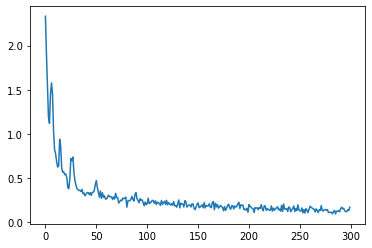

In [23]:
controller.recorder.plot_losses()

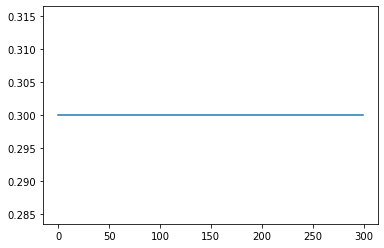

In [24]:
controller.recorder.plot_lrs()

## Scheduler Callback

In [25]:
class ParamScheduler(Callback):
    """
    Callback for scheduling any hyperparameter
    registered in the state dict of the optimizer
    """
    
    _order = 1
    
    def __init__(self, param_name, sched_funcs):
        self.pname, self.sched_funcs = param_name, sched_funcs
    
    def before_train(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)
    
    def set_param(self):
        assert len(self.opt.param_groups) == len(self.sched_funcs)
        for param_group, func in zip(self.opt.param_groups, self.sched_funcs):
            pos = self.n_epochs/self.epochs
            param_group[self.pname] = func(pos)
    
    def before_batch(self):
        if self.in_train: self.set_param()

In [26]:
def linear_scheduler(start, end):
    def _inner(pos): return start + (end-start)*pos
    return _inner        

**Initialize**

In [27]:
start_lr = 0.01
end_lr = 0.5

In [28]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=start_lr)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [29]:
cb_list = [StatsReporter([accuracy]),
           Recorder(),
           ParamScheduler('lr', linear_scheduler(start_lr, end_lr))]

In [30]:
controller = Controller(cb_list)
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 0.903 	 metrics: [0.76306] 	Valid loss: 0.326 	 metrics: [0.9069] 	
EPOCH#1 	Train loss: 0.322 	 metrics: [0.90388] 	Valid loss: 0.224 	 metrics: [0.9333] 	
EPOCH#2 	Train loss: 0.221 	 metrics: [0.93294] 	Valid loss: 0.150 	 metrics: [0.9585] 	


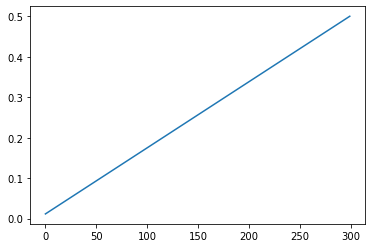

In [31]:
controller.recorder.plot_lrs()

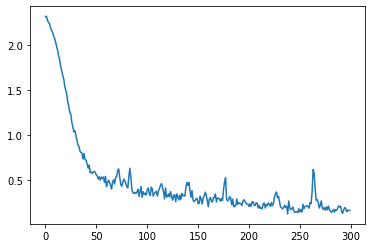

In [32]:
controller.recorder.plot_losses()

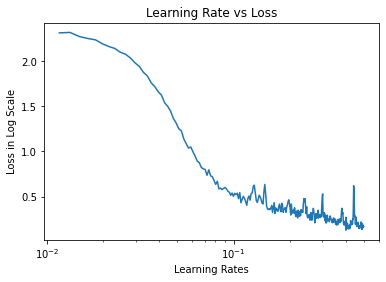

In [33]:
controller.recorder.plot()

# Cyclical Learning Rates
---

## Scheduling Functions

**Let's use a decorator instead of defining the same inner function in every scheduler**

In [34]:
def scheduler(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

In [36]:
@scheduler
def constant(start, end, pos):
    return start

@scheduler
def linear(start, end, pos):
    return start + (end-start)*pos

@scheduler
def exponential(start, end, pos):
    return start * (end/start)**pos

@scheduler
def cosine(start, end, pos):
    return start + (1 + math.cos(math.pi*(1-pos))) * (end-start)/2

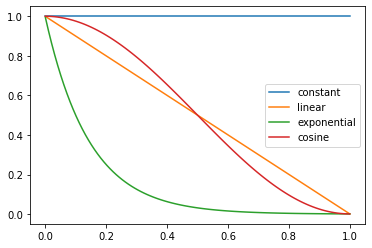

In [37]:
start = 1
end = 1e-3
xs = np.linspace(start, end, 100)
schedulers = [constant, linear, exponential, cosine]
names = ["constant", "linear", "exponential", "cosine"]

for sched, name in zip(schedulers, names):
    f = sched(start, end)
    ys = [f(x) for x in xs]
    plt.plot(xs, ys, label=name)
plt.legend();

## Mixed Schedules

In [38]:
def mixed_schedulers(pcts, schedulers):
    assert sum(pcts) == 1
    pcts = torch.tensor([0] + pcts)
    pcts = torch.cumsum(pcts, dim=0)
    def _inner(pos):
        idx = (pos > pcts).nonzero().max()
        lower_bound, upper_bound = pcts[idx], pcts[idx+1]
        relative_pos = (pos - lower_bound) / (upper_bound-lower_bound)
        return schedulers[idx](relative_pos)
    return _inner

## One Cycle Learning Rate Policy

**Increase the learning rate in the early epochs then gradually reduce it**

In [39]:
one_cycle_sched = mixed_schedulers(pcts = [0.3, 0.7],
                                   schedulers = [cosine(0.1,0.3),
                                                 cosine(0.3,0.001)])

/home/aman/anaconda3/envs/prod/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629401553/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  


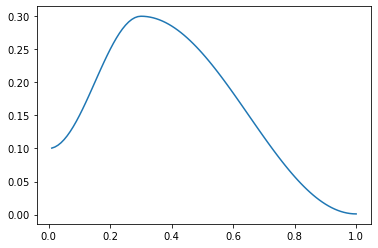

In [40]:
epochs = np.linspace(0.01, 1, 100)
lrs = [one_cycle_sched(x) for x in epochs]
plt.plot(epochs, lrs)

**Initialize**

In [41]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=start_lr)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [42]:
cb_list = [StatsReporter([accuracy]),
           Recorder(),
           ParamScheduler('lr', one_cycle_sched)]

In [43]:
controller = Controller(cb_list)
controller.train(learner, epochs=3)

EPOCH#0 	Train loss: 0.589 	 metrics: [0.83576] 	Valid loss: 0.246 	 metrics: [0.9292] 	
EPOCH#1 	Train loss: 0.219 	 metrics: [0.93502] 	Valid loss: 0.172 	 metrics: [0.9522] 	
EPOCH#2 	Train loss: 0.170 	 metrics: [0.9504] 	Valid loss: 0.162 	 metrics: [0.9547] 	


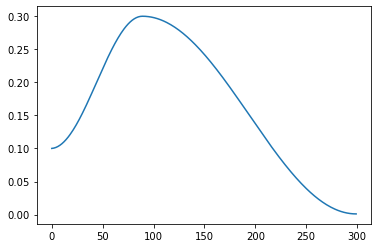

In [44]:
controller.recorder.plot_lrs()

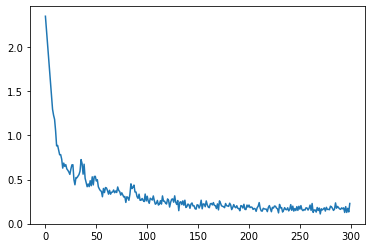

In [45]:
controller.recorder.plot_losses()

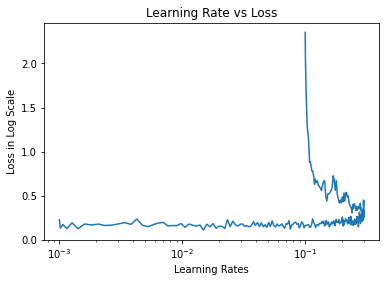

In [46]:
controller.recorder.plot()

## Stochastic Gradient with Restarts

In [39]:
sgdr_sched = mixed_schedulers(pcts = [0.1, 0.2, 0.3, 0.4],
                              schedulers = [cosine(0.01,0.001),
                                            cosine(0.01,0.001),
                                            cosine(0.01,0.001),
                                            cosine(0.01,0.001)])

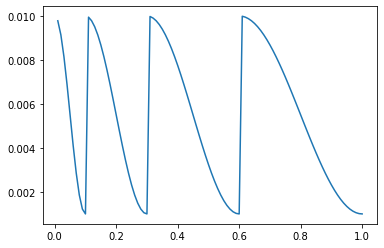

In [40]:
epochs = np.linspace(0.01, 1, 100)
lrs = [sgdr_sched(x) for x in epochs]
plt.plot(epochs, lrs)

**Initialize**

In [41]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=start_lr)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [42]:
cb_list = [StatsReporter([accuracy]),
           Recorder(),
           ParamScheduler('lr', sgdr_sched)]

In [43]:
controller = Controller(cb_list)
controller.train(learner, epochs=10)

EPOCH#0 	Train loss: 1.747 	 metrics: [0.59368] 	Valid loss: 1.446 	 metrics: [0.7402] 	
EPOCH#1 	Train loss: 1.052 	 metrics: [0.79124] 	Valid loss: 0.772 	 metrics: [0.8488] 	
EPOCH#2 	Train loss: 0.757 	 metrics: [0.8364] 	Valid loss: 0.682 	 metrics: [0.8612] 	
EPOCH#3 	Train loss: 0.629 	 metrics: [0.85616] 	Valid loss: 0.513 	 metrics: [0.8832] 	
EPOCH#4 	Train loss: 0.527 	 metrics: [0.87168] 	Valid loss: 0.462 	 metrics: [0.8909] 	
EPOCH#5 	Train loss: 0.497 	 metrics: [0.87686] 	Valid loss: 0.449 	 metrics: [0.8933] 	
EPOCH#6 	Train loss: 0.464 	 metrics: [0.88162] 	Valid loss: 0.400 	 metrics: [0.8995] 	
EPOCH#7 	Train loss: 0.426 	 metrics: [0.88786] 	Valid loss: 0.376 	 metrics: [0.9029] 	
EPOCH#8 	Train loss: 0.407 	 metrics: [0.8909] 	Valid loss: 0.366 	 metrics: [0.9045] 	
EPOCH#9 	Train loss: 0.400 	 metrics: [0.89258] 	Valid loss: 0.362 	 metrics: [0.9054] 	


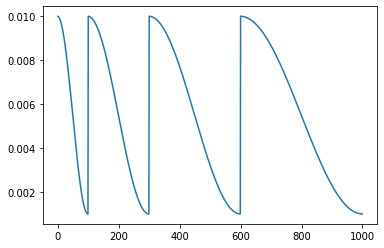

In [44]:
controller.recorder.plot_lrs()

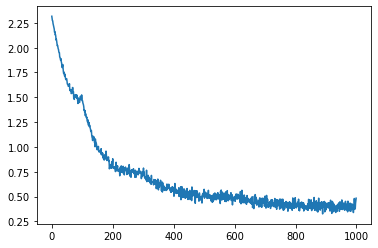

In [45]:
controller.recorder.plot_losses()

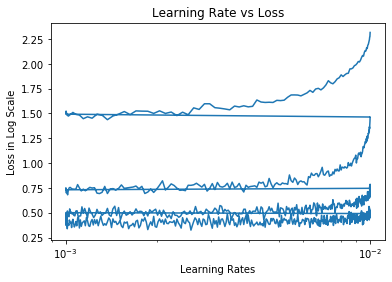

In [46]:
controller.recorder.plot()

# Discriminative Learning Rates
---

**Initialize Learner**

In [47]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

## Custom Parameter Groups

**For example, let's set different learning rates for the weights and biases of the model:**  
Specifying Learning Rates per Layer: (https://pytorch.org/docs/stable/optim.html)

In [48]:
weights, biases = [], []

for layer in model:
    if hasattr(layer, 'weight'):  weights.append(layer.weight)
    if hasattr(layer, 'bias'):    biases.append(layer.bias)

In [49]:
custom_param_groups = [{'params': weights}, {'params': biases}]

In [50]:
opt = torch.optim.SGD(custom_param_groups, lr=start_lr)
loss_func = F.cross_entropy
learner = utils.Learner(model, data, opt, loss_func)

## Learning Rates for each Group

In [51]:
sched_weights = mixed_schedulers(pcts = [0.3, 0.7], schedulers = [cosine(0.2,0.6), cosine(0.6,0.1)])
sched_biases  = mixed_schedulers(pcts = [0.3, 0.7], schedulers = [cosine(0.3,0.9), cosine(0.9,0.2)])

**Train**

In [52]:
cb_list = [StatsReporter([accuracy]),
           Recorder(),
           ParamScheduler('lr', [sched_weights, sched_biases])]

In [53]:
controller = Controller(cb_list)
controller.train(learner, epochs=10)

EPOCH#0 	Train loss: 0.497 	 metrics: [0.85296] 	Valid loss: 0.260 	 metrics: [0.9246] 	
EPOCH#1 	Train loss: 0.241 	 metrics: [0.92658] 	Valid loss: 0.164 	 metrics: [0.9511] 	
EPOCH#2 	Train loss: 0.185 	 metrics: [0.94428] 	Valid loss: 0.122 	 metrics: [0.9627] 	
EPOCH#3 	Train loss: 0.109 	 metrics: [0.96724] 	Valid loss: 0.107 	 metrics: [0.9666] 	
EPOCH#4 	Train loss: 0.085 	 metrics: [0.97532] 	Valid loss: 0.093 	 metrics: [0.9714] 	
EPOCH#5 	Train loss: 0.066 	 metrics: [0.98038] 	Valid loss: 0.084 	 metrics: [0.9746] 	
EPOCH#6 	Train loss: 0.054 	 metrics: [0.98488] 	Valid loss: 0.080 	 metrics: [0.9755] 	
EPOCH#7 	Train loss: 0.046 	 metrics: [0.98772] 	Valid loss: 0.078 	 metrics: [0.9779] 	
EPOCH#8 	Train loss: 0.041 	 metrics: [0.98936] 	Valid loss: 0.075 	 metrics: [0.9779] 	
EPOCH#9 	Train loss: 0.038 	 metrics: [0.99026] 	Valid loss: 0.075 	 metrics: [0.978] 	


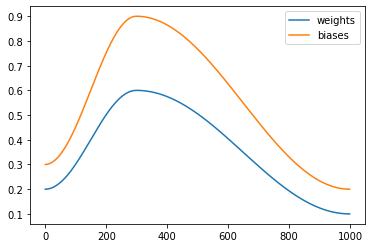

In [54]:
controller.recorder.plot_lrs(param_group_id=0)
controller.recorder.plot_lrs(param_group_id=1)
plt.legend(["weights", "biases"])

# Optimal Learning Rate Finder
---

**TODO:**
* Save model before LR_Find is called and load the model weights after it has completed
* Exponential smoothing of the loss for eliminating noise

In [93]:
class LR_Finder(Callback):
    """
    Finding the best learning rate
    by varying it between reasonable bounds
    and picking the one with the best loss
    """
    
    def __init__(self, min_lr=1e-6, max_lr=10, max_iters=100):
        self.min_lr, self.max_lr, self.max_iters = min_lr, max_lr, max_iters
        self.best_loss = 1e9
    
    def before_batch(self):
        if not self.in_train: return 
        i = self.n_iter/self.max_iters
        lr = self.min_lr * (self.max_lr/self.min_lr)**i
        for group in self.opt.param_groups:
            group['lr'] = lr
    
    def after_step(self):
        if self.n_iter > self.max_iters or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss
    
    def after_cancel_train(self):
        print(f"LR Finder found best loss of {self.best_loss:.4f}") 
        print("Plot the 'Learning Rate VS Loss' curve to find the best learning rate")

**Initialize**

In [94]:
m = data.train_ds.x.shape[1]
c = data.n_classes
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, c))

opt = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_func = F.cross_entropy

learner = utils.Learner(model, data, opt, loss_func)

**Train with Callbacks**

In [95]:
cb_list = [Recorder(),
           LR_Finder()]

In [96]:
controller = Controller(cb_list)
controller.train(learner, epochs=10)

LR Finder found best loss of 0.8487
Plot the 'Learning Rate VS Loss' curve to find the best learning rate


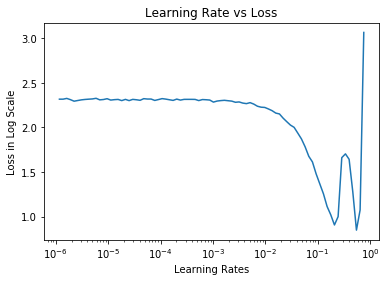

In [97]:
controller.recorder.plot(skip_last=5)

**Best Learning Rate: $10^{-1}$** (when the loss is still converging towards the best loss)